# To do:

## To check:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 140)
import sys, os
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime

In [2]:
sys.path.append(os.path.join(os.path.curdir, '..', 'sentiment_sports'))
import sports_sentiment as ss

C:\Users\map22\Anaconda3\lib\site-packages\distributed\utils.py:129: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  % (host, default, e), RuntimeWarning)


In [3]:
fs = 14

### Load sentiment analyzer

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
stat_words = ['win', 'kills']
neutral_words = ['dire',  'leaked', 'play', 'shoot', 'kill', 'assault', 'playing', 'played', 'killed',
                 'sparkle', 'prisoner', 'winner', 'win', 'ruin', 'pay', 'gun', 'fury',
                 'destroyer', 'radiant', 'poised', 'merry', 'honor', 'grit', 'threat',
                 'wreck', 'havoc', 'battle', 'heartbreaker', 'devastator','dynamic', 'stalwart', 'daring',
                'rebel', 'prickly', 'scarecrow', 'apocalyptic', 'definitely', 'please']
bad_words = ['uninstall', 'noob', 'nub', 'bot']
great_words = ['clutch', 'dope', 'fire', '💗']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-1 for word in bad_words})
sid.lexicon.update({word:1.5 for word in great_words})

C:\Users\map22\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Create words for known token NER
Load a list of all skins

In [5]:
skin_df = pd.read_csv('modeling_data/labeled_skin_covariates.tsv', sep='\t')
skin_df['release_datetime'] = pd.to_datetime(skin_df['release_datetime'])
skin_df['days_since_release'] = (datetime.now() - skin_df['release_datetime']).dt.days

In [6]:
skin_df['skins_str'] = skin_df['skin_name'].str.lower()
skin_df['skins_str'] = skin_df['skins_str'].str.strip('.!').str.replace('the ', '')
skin_df['gender'] = skin_df['gender'].fillna('non-human-gender')
skin_df[skin_df['gender'] == 'non-human']['race'] = 'non-human-race'
skin_df['race'] = skin_df['race'].fillna('unclear_race')
skin_df['battle_pass'] = skin_df['skin_source'].str.contains('Battle Pass')
skin_df['v_bucks'] = skin_df['skin_source'].str.extract('(\d+) V-Bucks').fillna(0).astype(int)
skin_df['v_bucks'].value_counts()
skin_df['tier_1'] = skin_df['skin_source'].str.contains('Tier 1 ')
skin_df['tier_100'] = skin_df['skin_source'].str.contains('Tier 100')
skin_df['story_skin'] = skin_df['story_skin'].fillna(False)
skin_df.loc[skin_df['skin_name'] == "Vendetta",'tier_100'] = True

In [7]:
SKIN_SET = set(skin_df['skin_name'].tolist())
NAME_MAPPINGS= {'Yeehaw':'yee-haw', 'Yee haw':'yee-haw', 'Giddyup': 'giddy-up', 'Giddy up':'giddy-up',
                'Sunstrider':'sun strider',
                'Red-Nosed Ranger':'rednosed ranger','Red-Nosed Raider':'rednosed Raider',
               'Brute Gunner': 'B.R.U.T.E. Gunner', 'Brute Navigator': 'B.R.U.T.E. Navigator'}
NAME_MAPPINGS.update({k.lower():v for k,v in NAME_MAPPINGS.items()})
SKIN_SET = SKIN_SET | set(NAME_MAPPINGS.keys() )
SKIN_SET = SKIN_SET | set(skin.lower() for skin in SKIN_SET)
SKIN_SET = set(word.replace('the ', '') for word in SKIN_SET)
SKIN_SET = SKIN_SET | set(skin.replace('.', '') for skin in SKIN_SET )
UPPER_ENTITIES = {'A.I.M', 'Powder', 'Focus', 'Dream', 'Rush', 'Aim', 'Velocity',
                  'Guild', 'Grind', 'Ruin', 'Spike', 'Clutch', 'Bullseye',
                 'Fate', 'Oblivion', 'Splode', 'Scout', 'Rebel', 'Riot'}
MIXED_ENTITIES = set(skin.capitalize() for skin in SKIN_SET if len(skin.split()) > 1)
SKIN_SET = SKIN_SET -  {name.lower() for name in UPPER_ENTITIES} | UPPER_ENTITIES | MIXED_ENTITIES

Add streamers and game modes ("Blitz) to non skins set

In [8]:
NON_SKINS_SET = {'ninja', 'tfue', 'epic', 'bugha', 'reverse3k',
             'daequen', 'sypherpk', 'nickmercs', 'hamlinz', 'nickeh30',
             'Horde Rush', 'Aim assist', 'Storm tracker', 'Fortnite tracker', 'Blitz', 'blitz'}
NAMED_ENTITIES = SKIN_SET | NON_SKINS_SET
start_filter =  '^(' +  '|'.join( UPPER_ENTITIES) +')' # this may be too strict; I don't think Rush or Grind have this problem

## Load some data

In [8]:
months_2019 = [f'2019{month:02}' for month in range(1,8)]
months_2018 = [f'2018{month:02}' for month in range(1,13)]
months_overall = months_2018 + months_2019

In [ ]:
%%time
stub_loc = 'd:/data/fortnite/{}-fortnitebr-comments_submissions.tsv'
zipped_results = [ss.extract_skins_fortnite(stub_loc.format(month), NAMED_ENTITIES, NON_SKINS_SET, sid.polarity_scores) for month in months_overall]
all_extracted_df, all_single_df = zip(*zipped_results)

In [13]:
combined_extracted_df = pd.concat(all_extracted_df)
combined_single_df = pd.concat(all_single_df)
combined_single_df['skins_str'] = combined_single_df['extracted_skins'].str[0].str.lower()
combined_single_df['skins_str'] = combined_single_df['skins_str'].apply(lambda row: NAME_MAPPINGS[row] if row in NAME_MAPPINGS else row) # map names
combined_single_df = combined_single_df[~(combined_single_df['sentences'].str.lower() == combined_single_df['skins_str'])] # sentences where it is just the name of a skin

In [66]:
%%time
# easy way to recalculate sentiment after updating lexicon
combined_single_df = ss.calculate_sentiment(combined_single_df.drop(columns = ['neg', 'neu', 'pos', 'compound']),
                                                                    sid.polarity_scores)

Wall time: 1min 44s


In [67]:
combined_single_df['skins_str'].value_counts().tail(10)

dream flower          4
deep sea destroyer    3
banner trooper        3
branded brawler       3
deep sea dominator    3
marked marauder       2
chomp sr.             1
branded brigadier     1
bronto                1
tilted teknique       1
Name: skins_str, dtype: int64

#### Verify that extraction is working correctly

### Save / load

In [9]:
combined_single_df = pd.read_csv('modeling_data/comments_with_single_skins.tsv', sep='\t')
combined_extracted_df = pd.read_pickle('modeling_data/comments_with_n_skins.pkl')

### Exploration

In [10]:
exploded_df = combined_extracted_df.explode('extracted_skins')
exploded_df['skins_str'] = exploded_df['extracted_skins'].str.lower()
exploded_df['skins_str'] = exploded_df['skins_str'].apply(lambda row: NAME_MAPPINGS[row] if row in NAME_MAPPINGS else row)
skin_counts_series = exploded_df['extracted_skins'].str.lower().value_counts()

In [11]:
pd.DataFrame(skin_counts_series.head(5))

,extracted_skins
omega,40270
john wick,29912
drift,29396
skull trooper,23474
black knight,17885


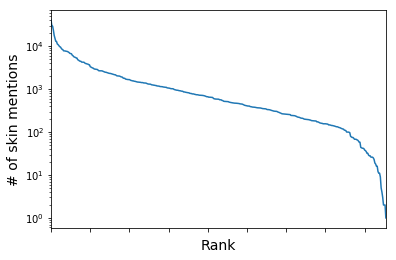

In [12]:
fig, ax = plt.subplots(1)
skin_counts_series.plot.line()
plt.yscale('log')
plt.ylabel('# of skin mentions', fontsize =fs)
plt.xlabel('Rank', fontsize =fs)
ax.set_xticklabels([]);
fig.savefig('skin_popularity.png', dpi=300)

## Comment counts
### Aggregation

In [13]:
skin_counts_df = exploded_df.skins_str.value_counts().reset_index().rename(columns = {'skins_str':'skins_count', 'index':'skins_str'})
skin_df = skin_df.merge(skin_counts_df, how='left', on='skins_str')
#skin_df[skin_df['skins_count'].isna()]

In [14]:
skin_df.sample(3)

,skin_name,skin_source,skin_rarity,race,gender,story_skin,skin_set,release_date,release_datetime,days_since_release,skins_str,battle_pass,v_bucks,tier_1,tier_100,skins_count
56,Bunnymoon,800 V-Bucks,Uncommon,W,F,False,NaN,28-Oct-18,2018-10-28,313.0,bunnymoon,False,800,False,False,730.0
7,Alpine Ace,1500 V-Bucks,Epic,unclear_race,M,False,Winter Ski,6-Feb-18,2018-02-06,577.0,alpine ace,False,1500,False,False,2257.0
104,Dire,Reach Tier 100 in Season 6 Battle Pass,Legendary,W,M,False,Full Moon,9/27/2018,2018-09-27,344.0,dire,True,0,False,True,11269.0


### Exploration

In [31]:
skin_df.groupby(['battle_pass']).mean()['skins_count']

battle_pass
False    1286.317416
True     4779.777778
Name: skins_count, dtype: float64

In [247]:
skin_df.groupby('skin_rarity').mean()['skins_count']

skin_rarity
\r\n          510.571429
Epic         1293.460123
Legendary    4979.760000
Rare          821.336449
Uncommon      741.631579
Name: skins_count, dtype: float64

In [248]:
skin_df.groupby('race').mean()['skins_count']

race
A                888.500000
B               2623.175000
L               1682.533333
W               1461.672956
unclear_race    1914.445783
Name: skins_count, dtype: float64

In [249]:
skin_df.groupby('gender').mean()['skins_count']

gender
F                   1297.361582
M                   2121.726872
non-human-gender    1356.200000
Name: skins_count, dtype: float64

In [250]:
skin_df.groupby(['tier_1', 'tier_100']).mean()['skins_count']

tier_1  tier_100
False   False        1446.971795
        True        12333.285714
True    False        5616.166667
Name: skins_count, dtype: float64

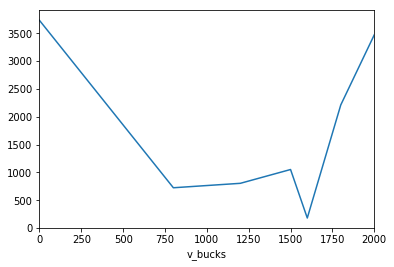

In [32]:
skin_df.groupby('v_bucks').mean()['skins_count'].plot();

### Regression

In [33]:
count_fit_df = skin_df.dropna(subset = ['skins_count']).fillna({'story_skin':False, 'skin_rarity':'Uncommon'})
count_fit_df['log_count'] = np.log(count_fit_df['skins_count'])

In [34]:
count_model = smf.wls( formula = 'log_count ~ race + gender + days_since_release +' \
                                  'tier_1 + tier_100 + battle_pass+ v_bucks + story_skin  ',
                data = count_fit_df#,
#               weights = 1# / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [35]:
count_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_count   R-squared:                       0.366
Model:                            WLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     18.87
Date:                Fri, 06 Sep 2019   Prob (F-statistic):           2.74e-32
Time:                        04:49:37   Log-Likelihood:                -669.95
No. Observations:                 405   AIC:                             1366.
Df Residuals:                     392   BIC:                             1418.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.5095      0.405     11.124      0.000       3.712       5.307
race[T.B]                     -0.3151      0.407     -0.774      0.440      -1.116       0.486
race[T.L]                     -0.2471      0.431     -0.573      0.567      -1.095       0.601
race[T.W]                      0.0075      0.360      0.021      0.983      -0.700       0.715
race[T.unclear_race]           0.4914      0.362      1.359      0.175      -0.220       1.202
gender[T.M]                   -0.1026      0.139     -0.740      0.460      -0.376       0.170
gender[T.non-human-gender]     0.3787      0.601      0.630      0.529      -0.803       1.560
tier_1[T.True]                 0.5958      0.436      1.368      0.172      -0.261       1.452
tier_100[T.True]               1.3256      0.540      2.453      0.015       0.263       2.388
battle_pass[T.True]            1.3623      0.292      4.667      0.000       0.788       1.936
story_skin[T.True]             2.1310      0.668      3.191      0.002       0.818       3.444
days_since_release             0.0040      0.000     10.523      0.000       0.003       0.005
v_bucks                        0.0002      0.000      1.268      0.206      -0.000       0.000
==============================================================================
Omnibus:                       31.164   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.111
Skew:                          -0.401   Prob(JB):                     5.96e-16
Kurtosis:                       4.874   Cond. No.                     1.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Sentiment
### Validation

In [16]:
sentiment_df = combined_single_df.copy()
SENTIMENT_SKINS = set([ 'love ranger', 'super striker', 'strong guard', 'special forces',
                      'honor guard', 'lucky rider', 'fallen love ranger', 'insight', 'dream', 'riot',
                      'brilliant striker', 'clutch', 'spike', 'guild'])
sentiment_df = sentiment_df[~sentiment_df.skins_str.isin(SENTIMENT_SKINS)]
sentiment_df = sentiment_df[sentiment_df['sentences'].str.len() <=100]

In [43]:
sid.lexicon['valor']

KeyError: 'valor'

In [70]:
sentiment_df.query('skins_str == "psion"').sample(5)[['sentences', 'compound']]

,sentences,compound
181806,"Psion for the win, baby",0.0000
149896,Psion Flayers,0.0000
172637,"I was saving my vbucks for Psion, but oh well",0.3919
224562,Psion wallpaper [Blender],0.0000
173438,"Psion, a leaked skin",0.0000


In [71]:
sentiment_df.groupby('skins_str').mean()['compound'].sort_values(ascending=False).head(15)
#combined_single_df[combined_single_df['sentences'].str.contains('devastator')]['sentences'].sample(10)
#sentiment_df.query('skins_str == "branded brigadier"')

skins_str
branded brigadier      0.458800
chomp sr.              0.457600
deep sea destroyer     0.348800
deep sea dominator     0.335250
marked marauder        0.318450
snowstrike             0.224732
molten valkyrie        0.223673
psion                  0.218192
straw ops              0.217257
molten battle hound    0.213833
bronto                 0.212900
scarlet defender       0.207801
tsuki                  0.203786
stalwart sweeper       0.203714
axiom                  0.198358
Name: compound, dtype: float64

In [50]:
combined_single_df.query('compound != 0 and skins_str != "prisoner" and skins_str != "dire"').sample(10)[['sentences', 'compound']]

,sentences,compound
60827,"To be fair I play Raptor a lot and hardly see other Raptors, the 2000 V Buck skins are pretty rare overall",0.6705
47292,"Nope, im at season lvl 65 and still need to grind 12k exp a day to reach lvl 80 As for tier there are only 3 weekly challenges left whic...",0.1027
100417,I would greatly appreciate if you made one for me containing Triple Threat,0.4576
82868,"I’m getting stage slayer because he looks like my favorite singer, Ronnie Van Zant",0.6705
213278,"It turns out, the visitor had been lost in the universe",-0.3182
96150,"Its the favoured character model, with a simple, clean design that goes well with a lot of different backblings, wanna rock the red knig...",0.7650
159261,"At least he was right about the leviathan ltm, that mode was amazing",0.5859
151505,They made so no one ever ends up how they would end up in season 4: a level 4 Omega with only one color :(,-0.6972
116869,Trailblazer (beacuse it is my fav skin) starter pack 1# backpack and trusty no.2,0.7351
118804,I kind of like Drift the way he is for colors,0.3612


### Aggregation

In [17]:
user_skin_sentiment_df = (sentiment_df.groupby(['user','skins_str'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_skin_sentiment_df.columns = ['user','skins_str', 'compound_mean', 'compound_std', 'comment_count']
user_skin_sentiment_df.head(2)

,user,skins_str,compound_mean,compound_std,comment_count
0,---100,cuddle team leader,0.0,NaN,1
1,---100,enforcer,0.0,NaN,1


#### Then calculate the average sentiment to skins across all users

In [18]:
skin_sentiment_df = (user_skin_sentiment_df#.query('compound_mean != 0')
                                           .groupby('skins_str')
                                           .agg({'compound_mean':['mean', 'std', 'count']})
                                           .reset_index() )
skin_sentiment_df.columns = ['skins_str', 'mean_sentiment', 'compound_mean_std', 'user_count']

### Exploration

In [19]:
sentiment_fit_df = skin_df.merge(skin_sentiment_df, on = 'skins_str')

#### Lowest sentiment

In [22]:
sentiment_fit_df.query('user_count > 20').sort_values('mean_sentiment').head(5)[['skin_name', 'mean_sentiment']]

,skin_name,mean_sentiment
301,Shaman,-0.107155
30,Birdie,-0.058408
168,Hypernova,-0.045983
68,Cloudbreaker,-0.042364
232,Nitehare,-0.023759


#### Highest sentiment

In [23]:
sentiment_fit_df.query('user_count > 20').sort_values('mean_sentiment').tail(5)[['skin_name', 'mean_sentiment']]

,skin_name,mean_sentiment
231,Nitebeam,0.192443
368,Tsuki,0.205040
291,Scarlet Defender,0.205750
255,Psion,0.224389
332,Straw Ops,0.231058


In [24]:
combined_single_df.query('skins_str == "psion"')[['sentences', 'compound']].sample(10)

,sentences,compound
170587,"Psion: ""Mind over matter.""",0.0000
239727,The girl is Psion,0.0000
163667,Psion should've had her whole face covered behind a mask... [removed],0.0000
174274,I've got a wart on my foot and goddamn does it bother me Psion is so fucking cute I love her,0.5877
173994,I'm thinking of about it too but Psion looks pretty nice as well,0.8922
173439,"It's a leaked skin called ""Psion""",0.0000
149896,Psion Flayers,0.0000
173803,"Psion is pretty cool, one of the better wildcat skins",0.8126
181806,"Psion for the win, baby",0.0000
182908,I came looking for validation on Psion and got literally none,0.0000


In [25]:
sentiment_fit_df.groupby('gender').mean()['mean_sentiment']

gender
F                   0.093838
M                   0.075949
non-human-gender    0.102083
Name: mean_sentiment, dtype: float64

In [27]:
sentiment_fit_df.describe()['mean_sentiment']

count    394.000000
mean       0.084181
std        0.057831
min       -0.136300
25%        0.051261
50%        0.083379
75%        0.112584
max        0.458800
Name: mean_sentiment, dtype: float64

In [471]:
sentiment_fit_df.groupby('race').mean()['compound_mean_mean']

race
A               0.122676
B               0.073971
L               0.099930
W               0.094323
unclear_race    0.087108
Name: compound_mean_mean, dtype: float64

In [30]:
sentiment_bins = np.arange(-0.1, 0.35, 0.025)
male_hist,_ = np.histogram(sentiment_fit_df.query('gender == "M"')['mean_sentiment'], bins=sentiment_bins)
female_hist,_ = np.histogram(sentiment_fit_df.query('gender == "F"')['mean_sentiment'], bins=sentiment_bins)

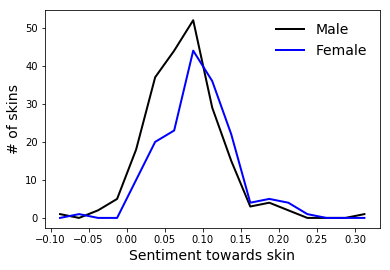

In [40]:
fig, ax = plt.subplots(1)
plt.plot(sentiment_bins[:-1]+0.0125, male_hist, color='k', linewidth=2, label = 'Male');
plt.plot(sentiment_bins[:-1]+0.0125, female_hist, color='b', linewidth=2, label='Female');
plt.ylabel('# of skins', fontsize = fs)
plt.xlabel('Sentiment towards skin', fontsize = fs);
plt.legend(frameon=False, fontsize = fs)
fig.savefig('sentiment_hist.png')

### Regression
#### Full model

In [90]:
sentiment_model = smf.wls( formula = 'mean_sentiment ~  race + gender + days_since_release +' \
                                  'tier_1 + tier_100 + battle_pass+ v_bucks',
                data = sentiment_fit_df,
               weights = 1 / (sentiment_fit_df['compound_mean_std'] / np.sqrt(sentiment_fit_df['user_count']))
#                missing='raise'   
               ).fit()

In [91]:
sentiment_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         mean_sentiment   R-squared:                       0.057
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.054
Date:                Fri, 06 Sep 2019   Prob (F-statistic):             0.0228
Time:                        05:05:24   Log-Likelihood:                 678.74
No. Observations:                 386   AIC:                            -1333.
Df Residuals:                     374   BIC:                            -1286.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0964      0.013      7.281      0.000       0.070       0.122
race[T.B]                     -0.0320      0.013     -2.398      0.017      -0.058      -0.006
race[T.L]                     -0.0142      0.014     -1.045      0.297      -0.041       0.013
race[T.W]                     -0.0185      0.012     -1.533      0.126      -0.042       0.005
race[T.unclear_race]          -0.0210      0.012     -1.752      0.081      -0.045       0.003
gender[T.M]                   -0.0120      0.004     -2.729      0.007      -0.021      -0.003
gender[T.non-human-gender]     0.0010      0.017      0.057      0.954      -0.033       0.035
tier_1[T.True]                 0.0089      0.010      0.890      0.374      -0.011       0.029
tier_100[T.True]               0.0082      0.010      0.799      0.425      -0.012       0.028
battle_pass[T.True]            0.0015      0.008      0.202      0.840      -0.014       0.017
days_since_release          1.123e-05   1.15e-05      0.979      0.328   -1.13e-05    3.38e-05
v_bucks                      3.66e-06   3.91e-06      0.935      0.350   -4.03e-06    1.14e-05
==============================================================================
Omnibus:                        2.011   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.760
Skew:                          -0.145   Prob(JB):                        0.415
Kurtosis:                       3.159   Cond. No.                     1.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Gender and race only

In [92]:
sentiment_model_gender = smf.wls( formula = 'mean_sentiment ~  race + gender',
                data = sentiment_fit_df,
               weights = 1 / (sentiment_fit_df['compound_mean_std'] / np.sqrt(sentiment_fit_df['user_count']))
#                missing='raise'   
               ).fit()

In [93]:
sentiment_model_gender.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         mean_sentiment   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.102
Date:                Fri, 06 Sep 2019   Prob (F-statistic):            0.00560
Time:                        05:06:16   Log-Likelihood:                 682.51
No. Observations:                 391   AIC:                            -1351.
Df Residuals:                     384   BIC:                            -1323.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1050      0.012      8.934      0.000       0.082       0.128
race[T.B]                     -0.0317      0.013     -2.377      0.018      -0.058      -0.005
race[T.L]                     -0.0128      0.013     -0.958      0.339      -0.039       0.013
race[T.W]                     -0.0192      0.012     -1.595      0.111      -0.043       0.004
race[T.unclear_race]          -0.0215      0.012     -1.796      0.073      -0.045       0.002
gender[T.M]                   -0.0108      0.004     -2.518      0.012      -0.019      -0.002
gender[T.non-human-gender]    -0.0007      0.017     -0.043      0.965      -0.034       0.033
==============================================================================
Omnibus:                        2.412   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                2.201
Skew:                          -0.177   Prob(JB):                        0.333
Kurtosis:                       3.101   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Old NER code (didn't work due to too many common words and reused words across skins)

In [83]:
%%time
# 1 min if memory constrained
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
ddf = dd.from_pandas(july_sentences_df, npartitions=12)
test_df= ddf.map_partitions(lambda df: ss.extract_known_ner(df, NAMED_ENTITIES, UPPER_ENTITIES)).compute()
client.close()


Wall time: 33.9 s


In [84]:
%%time
#test_df = ss.extract_known_ner(july_sentences_df, NAMED_ENTITIES, UPPER_ENTITIES)
test_df = ss.clean_entities(test_df, non_players_set=NON_SKINS,max_entities = 4)

Outputting 90243 sentences which have 1-2 named entities
Wall time: 5.04 s


In [94]:
test_df['skin_match'] = test_df['str_entities'].apply(lambda row: row in skin_set)
test_df.query('skin_match')['str_entities'].value_counts().head(20)

singularity      1028
drift             720
fishstick         555
grind             438
peely             432
omega             299
beach bomber      287
marshmello        280
ruin              256
breakpoint        243
john wick         232
demogorgon        225
vendetta          197
luxe              183
demi              165
ikonik            159
rust lord         147
hopper            123
rox               118
bunker jonesy     114
Name: str_entities, dtype: int64